# GTZAN Image Classification Transfer Learning

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

import librosa
import librosa.display
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import os
general_path = '/Users/hannahgracesmith/Desktop/DS207_final_project/Data'

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [4]:
# Import the libraries for images
from PIL import Image
import io
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

## Transfer Learning

Source: https://github.com/Ishaanidisha/W207-Fall-2023/blob/main/MIscellaneous/Week%2009/Transfer_learning_CIFAR.ipynb

### Import libraries

In [5]:
from __future__ import print_function

from time import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
import random

### Filters, pool size, and kernel size

In [6]:
# size of pooling area for max pooling
pool_size = (3,3)

# convolution kernel size
kernel_size = (5,5)

# strides
stride_size = (2,2)

### Load data

In [7]:
# Directory
root_dir = '/Users/hannahgracesmith/Desktop/DS207_final_project/Data/images_original'

# Import the data
image_data = []
labels = []

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(folder_path, image_file)
                image = Image.open(image_path)
                image_array = np.array(image)
                image_data.append(image_array)
                labels.append(folder)

### Prepare the Data

In [8]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(np.array(image_data).astype('uint8'), labels, test_size=0.2)

In [9]:
# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Create and fit the label encoder
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)

label_names = ['blues', 'classical', 'country', 'disco', 'hiphop',
               'jazz', 'metal', 'pop', 'reggae', 'rock']

# Shuffle the training data
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [10]:
# Preprocessing
IMAGE_SIZE = (288, 432)
CONTRAST_FACTOR = 3
DELTA = 0.3

### image transformation on training and test data ###
###################################################################
# image resize
X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
X_test = tf.image.resize(X_test, size=IMAGE_SIZE)

### image augmentation on training data ###
###########################################
# adjust brightness
X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

# adjust contrast
X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

# random flip
X_train_augm = tf.image.random_flip_left_right(X_train_augm)

# concatenate original X_train and augmented X_train data
X_train = tf.concat([X_train, X_train_augm],axis=0)

# concatenate Y_train (note the label is preserved)
Y_train_augm = Y_train
Y_train = tf.concat([Y_train, Y_train_augm],axis=0)

# shuffle X_train and Y_train, i.e., shuffle two tensors in the same order
shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
X_train = tf.gather(X_train, shuffle)
Y_train = tf.gather(Y_train, shuffle).numpy() #also transforms Y_train to numpy array

2023-12-13 23:18:29.492035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set the number of classes and the input shape

In [11]:
num_classes = 10
input_shape = (288, 432, 4)

### Define two groups of layers: feature (convolutions) and classification (dense)

In [12]:
feature_layers = [
    Conv2D(filters=32,
    kernel_size=kernel_size,
    strides=stride_size,
    padding='same',
    data_format='channels_last',
    input_shape=input_shape,
    activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Conv2D(filters=64,
    kernel_size=kernel_size,
    strides=stride_size,
    padding='same',
    data_format='channels_last',
    activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Flatten()
]

In [13]:
classification_layers = [
    Dense(512),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes),
    Activation('softmax')
]

### Create the complete model by stacking together `feature_layers` and `classification_layers`

In [14]:
model_1 = Sequential(feature_layers + classification_layers)

### Function definition for training a model

In [45]:
def train_model(model, train, test, num_classes,epochs=epochs):
    x_train = train[0]
    x_test = test[0]

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

    t1 = time()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time()
    t_delta = round(t2-t1,2)
    print('Training time: {} seconds'.format(t_delta))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

### Batch size and epochs

In [16]:
batch_size = 64
epochs = 30

In [17]:
X_test_sub = X_test[:150]
Y_test_sub = Y_test[:150]

### Train model for the first 5 categories of images

In [18]:
train_model(model_1,
            (X_train, Y_train),
            (X_test_sub, Y_test_sub),
            num_classes,
            epochs)

x_train shape: (1598, 288, 432, 4)
1598 train samples
150 test samples
Epoch 1/30
25/25 [==============================] - 53s 2s/step - loss: 2.2978 - accuracy: 0.1815 - val_loss: 2.2708 - val_accuracy: 0.1533
Epoch 2/30
25/25 [==============================] - 53s 2s/step - loss: 1.8926 - accuracy: 0.3323 - val_loss: 2.2334 - val_accuracy: 0.1067
Epoch 3/30
25/25 [==============================] - 50s 2s/step - loss: 1.6730 - accuracy: 0.4199 - val_loss: 2.1844 - val_accuracy: 0.3267
Epoch 4/30
25/25 [==============================] - 49s 2s/step - loss: 1.4937 - accuracy: 0.5044 - val_loss: 2.1963 - val_accuracy: 0.1067
Epoch 5/30
25/25 [==============================] - 49s 2s/step - loss: 1.3494 - accuracy: 0.5701 - val_loss: 2.1659 - val_accuracy: 0.3000
Epoch 6/30
25/25 [==============================] - 47s 2s/step - loss: 1.2135 - accuracy: 0.6070 - val_loss: 2.1683 - val_accuracy: 0.2533
Epoch 7/30
25/25 [==============================] - 46s 2s/step - loss: 1.0918 - accuracy

In [24]:
from sklearn.preprocessing import OneHotEncoder
#Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
Y_test_reshaped = Y_test.reshape(-1, 1)
Y_test_onehot = encoder.fit_transform(Y_test_reshaped)

In [25]:
test_results = model_1.evaluate(X_test, Y_test_onehot)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

7/7 [==============================] - 2s 204ms/step - loss: 1.0492 - accuracy: 0.6400

Test Acc. 64.00%


## Freeze

In [26]:
# Let's freeze a third of the layers
total_layers = len(feature_layers)
num_layers_to_freeze = total_layers // 3

for l in feature_layers[:num_layers_to_freeze]:
    l.trainable = False

In [38]:
model_2 = Sequential(feature_layers + classification_layers)

### Show the model summary and see that the features layers (Conv2D) have been renderd untrainable now

In [40]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 216, 32)      3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 72, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 36, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 12, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 512)              

In [29]:
# New data from the mel spectrograms
# Mel spectrograms
# Directory
root_dir = '/Users/hannahgracesmith/Desktop/DS207_final_project/Data/mel_spectrogram_imgs'

# Import the data
image_data = []
labels = []

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(folder_path, image_file)
                image = Image.open(image_path)
                image = image.resize((432, 288))  # Resize
                image_array = np.array(image)
                image_data.append(image_array)
                labels.append(folder)

In [52]:
### Prepare the Data
# Split the data
X_train_mel, X_test_mel, Y_train_mel, Y_test_mel = train_test_split(np.array(image_data).astype('uint8'), labels, test_size=0.2)

# Normalize the pixel values
X_train_mel = X_train_mel / 255.0
X_test_mel = X_test_mel / 255.0

In [53]:
# Create and fit the label encoder
label_encoder = LabelEncoder()
Y_train_mel = label_encoder.fit_transform(Y_train_mel)
Y_test_mel = label_encoder.transform(Y_test_mel)

# Shuffle the training data
np.random.seed(1)
indices = np.arange(X_train_mel.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_mel = X_train_mel[shuffled_indices]
Y_train_mel = Y_train_mel[shuffled_indices]

In [54]:
from sklearn.preprocessing import OneHotEncoder
#Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
Y_test_reshaped_mel = Y_test_mel.reshape(-1, 1)
Y_test_onehot_mel = encoder.fit_transform(Y_test_reshaped_mel)

X_test_sub_mel = X_test_mel[:150]
Y_test_sub_mel = Y_test_mel[:150]

In [55]:
# transfer: train dense layers for new classification task
input_shape = (288, 432, 4)
train_model(model_2,
            (X_train_mel, Y_train_mel),
            (X_test_sub_mel, Y_test_sub_mel),
            num_classes,
            epochs=10)

x_train shape: (799, 288, 432, 4)
799 train samples
150 test samples
Epoch 1/10
13/13 [==============================] - 17s 1s/step - loss: 0.2480 - accuracy: 0.9437 - val_loss: 7.7801 - val_accuracy: 0.2200
Epoch 2/10
13/13 [==============================] - 12s 946ms/step - loss: 0.1915 - accuracy: 0.9549 - val_loss: 8.7214 - val_accuracy: 0.2200
Epoch 3/10
13/13 [==============================] - 12s 938ms/step - loss: 0.1623 - accuracy: 0.9712 - val_loss: 6.0646 - val_accuracy: 0.2200
Epoch 4/10
13/13 [==============================] - 12s 894ms/step - loss: 0.1338 - accuracy: 0.9812 - val_loss: 3.3981 - val_accuracy: 0.3133
Epoch 5/10
13/13 [==============================] - 12s 954ms/step - loss: 0.1137 - accuracy: 0.9925 - val_loss: 2.2857 - val_accuracy: 0.4267
Epoch 6/10
13/13 [==============================] - 11s 869ms/step - loss: 0.1002 - accuracy: 0.9950 - val_loss: 1.8478 - val_accuracy: 0.4867
Epoch 7/10
13/13 [==============================] - 11s 847ms/step - loss: 0

In [57]:
test_results = model_2.evaluate(X_test_mel, Y_test_onehot_mel)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

7/7 [==============================] - 3s 311ms/step - loss: 0.6512 - accuracy: 0.8000

Test Acc. 80.00%


## Training Time

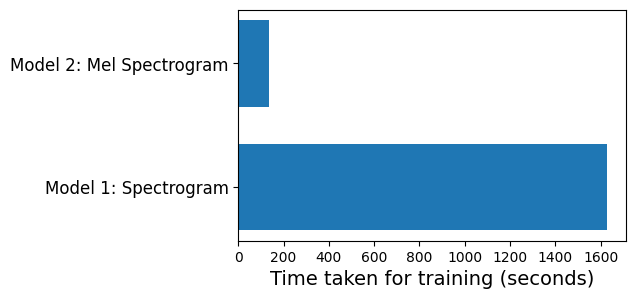

In [58]:
plt.figure(figsize=(5,3))
plt.barh(y=['Model 1: Spectrogram','Model 2: Mel Spectrogram'],width=[1629,136],height=0.7)
plt.xlabel("Time taken for training (seconds)",fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.show()